In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


In [ ]:
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import Dense, LSTM, Input, LayerNormalization, MultiHeadAttention

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
from tensorflow.keras.layers import Dense, LayerNormalization, MultiHeadAttention, Input
from tensorflow.keras.models import Model

In [ ]:
!mkdir Address
!mv *.txt ./Address/

In [ ]:
!ls Address/

sram10.txt  sram2.txt  sram4.txt  sram6.txt  sram8.txt
sram1.txt   sram3.txt  sram5.txt  sram7.txt  sram9.txt


In [ ]:
# Folder where your 10 SRAM files live
DATA_FOLDER = "./Address/"  # change this to your folder

In [ ]:
def load_puf_file(filepath):
    puf = {}

    with open(filepath, "rb") as f:
        raw = f.read()
    text = raw.decode("utf-8", errors="ignore")

    for line in text.splitlines():
        if "->" not in line:
            continue
        left, right = line.split("->")
        if ":" not in left:
            continue
        addr = left.split(":")[1].strip()
        bits = "".join(ch for ch in right.strip() if ch in "01")

        if addr not in puf:
            puf[addr] = bits

    return puf


In [ ]:
import os
import pandas as pd


In [ ]:
def load_all(folder):
    devices = {}
    files = sorted([f for f in os.listdir(folder) if f.endswith(".txt")])

    for i, fname in enumerate(files):
        devices[i] = load_puf_file(os.path.join(folder, fname))

    return devices, files

devices, file_names = load_all(DATA_FOLDER)
print("Loaded:", file_names)


Loaded: ['sram1.txt', 'sram10.txt', 'sram2.txt', 'sram3.txt', 'sram4.txt', 'sram5.txt', 'sram6.txt', 'sram7.txt', 'sram8.txt', 'sram9.txt']


In [ ]:
def get_common_addresses(devices):
    common = None
    for dev in devices.values():
        addr_set = set(dev.keys())
        common = addr_set if common is None else (common & addr_set)
    return sorted(list(common))

common_addrs = get_common_addresses(devices)
print("Common addresses:", len(common_addrs))


Common addresses: 2048


In [ ]:
def build_bit_dataset(devices, common_addresses):
    rows = []

    for dev_id, puf in devices.items():
        for addr in common_addresses:
            bitstring = puf[addr]
            for pos, bit in enumerate(bitstring):
                rows.append({
                    "device_id": dev_id,
                    "address": addr,
                    "pos": pos,
                    "bit": int(bit)
                })
    return pd.DataFrame(rows)

df = build_bit_dataset(devices, common_addrs)
df.head()


,device_id,address,pos,bit
0,0,0x3FFB0000,0,0
1,0,0x3FFB0000,1,1
2,0,0x3FFB0000,2,0
3,0,0x3FFB0000,3,1
4,0,0x3FFB0000,4,0


In [ ]:
## For MSB

def build_bit_dataset(devices, common_addresses):
    rows = []

    for dev_id, puf in devices.items():
        for addr in common_addresses:
            bitstring = puf[addr]
            lsb = int(bitstring[0])          # take only the first bit
            rows.append({
                "device_id": dev_id,
                "address": addr,
                "pos": 0,
                "bit": lsb
            })
    return pd.DataFrame(rows)

df = build_bit_dataset(devices, common_addrs)
df.head()


,device_id,address,pos,bit
0,0,0x3FFB0000,0,0
1,0,0x3FFB0001,0,1
2,0,0x3FFB0002,0,0
3,0,0x3FFB0003,0,1
4,0,0x3FFB0004,0,0


In [ ]:
addr_id_map = {addr: i for i, addr in enumerate(common_addrs)}
df["addr_id"] = df["address"].map(addr_id_map)


In [ ]:

X = df[["addr_id", "pos"]].values

# y is the PUF bit value
y = df["bit"].values

dev = df["device_id"].values


In [ ]:
train_mask = df["device_id"] <= 6
test_mask  = df["device_id"] >= 7

X_train = X[train_mask]
y_train = y[train_mask]

X_test = X[test_mask]
y_test = y[test_mask]


In [ ]:
class LSTMWrapper:
    def __init__(self, timesteps, epochs=30, batch_size=64):
        self.timesteps = timesteps
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = Sequential([
            LSTM(64, input_shape=(timesteps, 1)),
            Dense(1, activation="sigmoid")
        ])
        self.model.compile(
            optimizer="adam",
            loss="binary_crossentropy"
        )

    def fit(self, X, y):
        X = X.reshape((X.shape[0], self.timesteps, 1))
        self.model.fit(
            X, y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=0
        )

    def predict(self, X):
        X = X.reshape((X.shape[0], self.timesteps, 1))
        return self.model.predict(X, verbose=0).ravel()


In [ ]:
from tensorflow.keras.layers import (
    Dense,
    LayerNormalization,
    MultiHeadAttention,
    Input,
    GlobalAveragePooling1D
)

In [ ]:
class TransformerWrapper:
    def __init__(self, timesteps, heads=4, dim=32, epochs=30, batch_size=64):
        self.timesteps = timesteps
        self.epochs = epochs
        self.batch_size = batch_size

        inp = Input(shape=(timesteps, 1))

        attn = MultiHeadAttention(
            num_heads=heads,
            key_dim=dim
        )(inp, inp)

        x = LayerNormalization()(inp + attn)

        ff = Dense(dim, activation="relu")(x)
        ff = Dense(1)(ff)

        x = LayerNormalization()(x + ff)

        x = GlobalAveragePooling1D()(x)

        out = Dense(1, activation="sigmoid")(x)

        self.model = Model(inp, out)
        self.model.compile(
            optimizer="adam",
            loss="binary_crossentropy"
        )

    def fit(self, X, y):
        X = X.reshape((X.shape[0], self.timesteps, 1))
        self.model.fit(
            X, y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=0
        )

    def predict(self, X):
        X = X.reshape((X.shape[0], self.timesteps, 1))
        return self.model.predict(X, verbose=0).ravel()


In [ ]:
timesteps = X_train.shape[1]
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "RBF SVM": SVC(kernel="rbf", gamma="auto", probability=False),
    "Random Forest": RandomForestClassifier(n_estimators=300),
    "kNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=2000),
    "LSTM": LSTMWrapper(timesteps),
    "Transformer": TransformerWrapper(timesteps)
}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
from sklearn.metrics import accuracy_score, mean_absolute_error

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    # Flatten predictions if required
    if preds.ndim > 1:
        preds = preds.ravel()

    mae = mean_absolute_error(y_test, preds)

    # Threshold for accuracy computation
    preds_binary = (preds >= 0.5).astype(int)
    acc = accuracy_score(y_test, preds_binary)

    results[name] = {
        "MAE": mae,
        "Accuracy": acc
    }

    print(f"{name}: MAE = {mae:.6f}, Accuracy = {acc*100:.4f}%")


Logistic Regression: MAE = 0.506348, Accuracy = 49.3652%
RBF SVM: MAE = 0.493652, Accuracy = 50.6348%
Random Forest: MAE = 0.491048, Accuracy = 50.8952%
kNN: MAE = 0.492188, Accuracy = 50.7812%
Naive Bayes: MAE = 0.506348, Accuracy = 49.3652%
MLP: MAE = 0.494303, Accuracy = 50.5697%
LSTM: MAE = 0.504293, Accuracy = 49.5605%
Transformer: MAE = 0.505694, Accuracy = 49.3652%


In [ ]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_absolute_error,
    mean_squared_error
)

rows = []

for name, model in models.items():
    model.fit(X_train, y_train)

    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    if train_preds.ndim > 1:
        train_preds = train_preds.ravel()
    if test_preds.ndim > 1:
        test_preds = test_preds.ravel()

    train_bin = (train_preds >= 0.5).astype(int)
    test_bin = (test_preds >= 0.5).astype(int)

    row = {
        "Model": name,
        "Train Acc": accuracy_score(y_train, train_bin),
        "Test Acc": accuracy_score(y_test, test_bin),
        "Precision": precision_score(y_test, test_bin, zero_division=0),
        "Recall": recall_score(y_test, test_bin, zero_division=0),
        "F1": f1_score(y_test, test_bin, zero_division=0),
        "ROC AUC": roc_auc_score(y_test, test_preds),
        "MAE": mean_absolute_error(y_test, test_preds),
        "MSE": mean_squared_error(y_test, test_preds),
    }

    rows.append(row)

df = pd.DataFrame(rows)


In [ ]:
df

,Model,Train Acc,Test Acc,Precision,Recall,F1,ROC AUC,MAE,MSE
0,Logistic Regression,0.509835,0.493652,0.493652,1.000000,0.661000,0.500000,0.506348,0.506348
1,RBF SVM,0.649205,0.506348,0.500000,0.525223,0.512301,0.506584,0.493652,0.493652
2,Random Forest,0.674735,0.508952,0.502559,0.517969,0.510148,0.509065,0.491048,0.491048
3,kNN,0.655971,0.507812,0.501425,0.522255,0.511628,0.507994,0.492188,0.492188
4,Naive Bayes,0.509835,0.493652,0.493652,1.000000,0.661000,0.500000,0.506348,0.506348
5,MLP,0.510184,0.494466,0.494051,0.999341,0.661213,0.500795,0.505534,0.505534
6,LSTM,0.492746,0.507161,0.514620,0.029014,0.054931,0.506545,0.499859,0.249912
7,Transformer,0.509835,0.493652,0.493652,1.000000,0.661000,0.500000,0.500131,0.250239


In [ ]:
latex_table = df.to_latex(
    index=False,
    float_format="%.4f",
    caption="Model performance on address bit prediction task",
    label="tab:model_results"
)

with open("results.tex", "w") as f:
    f.write(latex_table)


In [ ]:
from sklearn.base import clone

def get_scores(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        return model.decision_function(X)
    else:
        return model.predict(X)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_absolute_error,
    mean_squared_error
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []

for name, model in models.items():

    cv_metrics = {
        "acc": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "roc_auc": []
    }

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        # Recreate model cleanly
        if name == "LSTM":
            m = LSTMWrapper(
                timesteps=model.timesteps,
                epochs=model.epochs,
                batch_size=model.batch_size
            )

        elif name == "Transformer":
            m = TransformerWrapper(
                timesteps=model.timesteps,
                epochs=model.epochs,
                batch_size=model.batch_size
            )

        else:
            m = clone(model)

        m.fit(X_tr, y_tr)

        val_scores = get_scores(m, X_val)
        val_bin = (val_scores >= 0.5).astype(int)

        cv_metrics["acc"].append(accuracy_score(y_val, val_bin))
        cv_metrics["precision"].append(
            precision_score(y_val, val_bin, zero_division=0)
        )
        cv_metrics["recall"].append(
            recall_score(y_val, val_bin, zero_division=0)
        )
        cv_metrics["f1"].append(
            f1_score(y_val, val_bin, zero_division=0)
        )

        if len(np.unique(y_val)) > 1:
            cv_metrics["roc_auc"].append(
                roc_auc_score(y_val, val_scores)
            )

    # Fit final model on full training data
    model.fit(X_train, y_train)

    test_scores = get_scores(model, X_test)
    test_bin = (test_scores >= 0.5).astype(int)

    row = {
        "Model": name,
        "CV Acc": np.mean(cv_metrics["acc"]),
        "CV Precision": np.mean(cv_metrics["precision"]),
        "CV Recall": np.mean(cv_metrics["recall"]),
        "CV F1": np.mean(cv_metrics["f1"]),
        "CV ROC AUC": np.mean(cv_metrics["roc_auc"])
        if cv_metrics["roc_auc"] else np.nan,
        "Test Acc": accuracy_score(y_test, test_bin),
        "Test Precision": precision_score(y_test, test_bin, zero_division=0),
        "Test Recall": recall_score(y_test, test_bin, zero_division=0),
        "Test F1": f1_score(y_test, test_bin, zero_division=0),
        "Test ROC AUC": roc_auc_score(y_test, test_scores),
        "MAE": mean_absolute_error(y_test, test_scores),
        "MSE": mean_squared_error(y_test, test_scores),
    }

    rows.append(row)

df = pd.DataFrame(rows)


KeyboardInterrupt: 

In [ ]:
df

,Model,CV Acc,CV Precision,CV Recall,CV F1,CV ROC AUC,Test Acc,Test Precision,Test Recall,Test F1,Test ROC AUC,MAE,MSE
0,Logistic Regression,0.509835,0.509835,1.000000,0.675352,0.498433,0.493652,0.493652,1.000000,0.661000,0.500885,0.500123,0.250221
1,RBF SVM,0.530484,0.549084,0.442331,0.489878,0.539822,0.508789,0.502870,0.433234,0.465462,0.507174,0.871692,1.169037
2,Random Forest,0.537389,0.546661,0.542482,0.544517,0.548011,0.508952,0.502559,0.517969,0.510148,0.507112,0.497699,0.291757
3,kNN,0.533064,0.542532,0.538650,0.540529,0.542123,0.507812,0.501425,0.522255,0.511628,0.510624,0.495280,0.306022
4,Naive Bayes,0.509138,0.509537,0.993434,0.673565,0.508288,0.493652,0.493652,1.000000,0.661000,0.496770,0.500145,0.250250
5,MLP,0.497699,0.489880,0.410811,0.291356,0.497137,0.494792,0.494208,0.998681,0.661209,0.500885,0.501218,0.266165
6,LSTM,0.506417,0.504848,0.792070,0.548162,0.505500,0.495768,0.494671,0.994725,0.660753,0.508976,0.500088,0.250461
7,Transformer,0.509835,0.509835,1.000000,0.675352,0.500205,0.493652,0.493652,1.000000,0.661000,0.500000,0.500116,0.250200


In [ ]:
latex_table = df.to_latex(
    index=False,
    float_format="%.4f",
    caption="Model performance on address bit prediction task",
    label="tab:model_results"
)

with open("results_cross_validation.tex", "w") as f:
    f.write(latex_table)


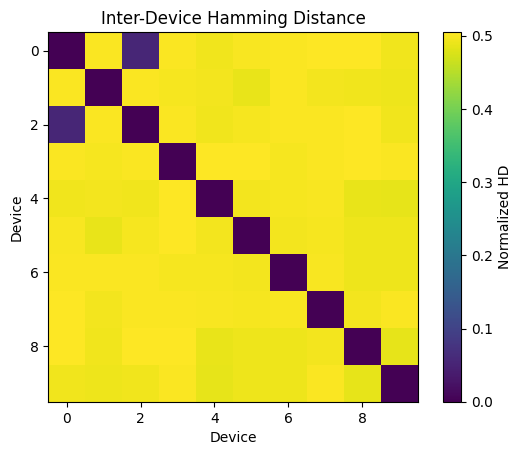

In [ ]:
def vec_from_device(dev_puf, addr_list):
    bits = []
    for addr in addr_list:
        bits.extend([int(b) for b in dev_puf[addr]])
    return np.array(bits)

vectors = []
for i in range(10):
    vectors.append(vec_from_device(devices[i], common_addrs))
vectors = np.vstack(vectors)

HD = np.zeros((10, 10))

for i in range(10):
    for j in range(10):
        HD[i,j] = np.mean(vectors[i] != vectors[j])

plt.imshow(HD, cmap="viridis")
plt.colorbar(label="Normalized HD")
plt.title("Inter-Device Hamming Distance")
plt.xlabel("Device")
plt.ylabel("Device")
plt.show()


In [ ]:
from collections import defaultdict, Counter
import re

def parse_device_file(path, bit_width=8):
    boots = []
    current_boot = {}
    # print("Current path is", path)
    with open(path, "r", encoding="latin-1") as f:
        for line in f:
            line = line.strip()
            if not line.startswith("Address:"):
                continue

            try:
                parts = line.split("->")
                addr_part = parts[0].replace("Address:", "").strip()
                raw_bits = parts[1]
                clean_bits = raw_bits
                # # Keep only 0 and 1
                # clean_bits = re.sub(r"[^01]", "", raw_bits)

                # # Enforce exact bit width
                # if len(clean_bits) != bit_width:
                #     continue

                addr = int(addr_part, 16)
                byte = int(clean_bits, 2)

                # New boot detected when address repeats
                if addr in current_boot:
                    boots.append(current_boot)
                    current_boot = {}

                current_boot[addr] = byte

            except Exception:
                continue

    if current_boot:
        boots.append(current_boot)
    # print("Number of boots is",len(boots))
    return boots


In [ ]:
def extract_bits(byte):
    bits = [(byte >> i) & 1 for i in range(8)]
    return {
        "LSB": bits[0],
        "MSB": bits[7],
        "XOR_MSB_LSB": bits[0] ^ bits[7],
        "XOR_ALL": sum(bits) % 2
    }


In [ ]:
def compute_stability(boots):
    common_addresses = set.intersection(*(set(b.keys()) for b in boots))

    # print("Common addresses are", len(common_addresses))

    stability = {
        "LSB": {},
        "MSB": {},
        "XOR_MSB_LSB": {},
        "XOR_ALL": {}
    }

    for addr in common_addresses:
        observed = defaultdict(list)
        # print("No of boots here are", boots)
        for boot in boots:
            metrics = extract_bits(boot[addr])
            # print("metrics value is", metrics)
            for k, v in metrics.items():
                observed[k].append(v)
                # print()

        for k, values in observed.items():
            counts = Counter(values)
            stability[k][addr] = max(counts.values()) / len(values)

    return stability


In [ ]:
device_results = {}

for i in range(1, 11):
    fname = f"Address/sram{i}.txt"
    boots = parse_device_file(fname)
    device_results[f"Device_{i}"] = compute_stability(boots)


In [ ]:

strategies = ["LSB", "MSB", "XOR_MSB_LSB", "XOR_ALL"]

comparison = {s: {"avg_stability": [], "stable_count": []} for s in strategies}

THRESHOLD = 1.0

for dev, stab in device_results.items():
    for s in strategies:
        values = list(stab[s].values())

        avg_stab = sum(values) / len(values)
        stable_cnt = sum(1 for v in values if v >= THRESHOLD)

        comparison[s]["avg_stability"].append(avg_stab)
        comparison[s]["stable_count"].append(stable_cnt)


In [ ]:
print("Stability comparison across strategies\n")

for s in strategies:
    avg_of_avg = sum(comparison[s]["avg_stability"]) / len(comparison[s]["avg_stability"])
    avg_count = sum(comparison[s]["stable_count"]) / len(comparison[s]["stable_count"])

    print(f"{s}")
    print(f"  Mean stability        : {avg_of_avg:.4f}")
    print(f"  Stable addresses ≥{THRESHOLD}: {avg_count:.1f}\n")


Stability comparison across strategies

LSB
  Mean stability        : 0.9642
  Stable addresses ≥1.0: 1682.6

MSB
  Mean stability        : 0.9644
  Stable addresses ≥1.0: 1686.4

XOR_MSB_LSB
  Mean stability        : 0.9315
  Stable addresses ≥1.0: 1384.9

XOR_ALL
  Mean stability        : 0.7841
  Stable addresses ≥1.0: 428.3



In [ ]:
def enrolled_response(boots, strategy):
    common_addresses = set.intersection(*(set(b.keys()) for b in boots))
    response = {}

    for addr in common_addresses:
        bits = []
        for boot in boots:
            byte = boot[addr]
            metrics = extract_bits(byte)
            bits.append(metrics[strategy])

        # majority vote
        response[addr] = 1 if sum(bits) >= len(bits) / 2 else 0

    return response


In [ ]:
strategies = ["LSB", "MSB", "XOR_MSB_LSB", "XOR_ALL"]

enrolled = {s: {} for s in strategies}

for i in range(1, 11):
    fname = f"Address/sram{i}.txt"
    boots = parse_device_file(fname)

    for s in strategies:
        enrolled[s][f"Device_{i}"] = enrolled_response(boots, s)


In [ ]:
import itertools

def hamming_distance(r1, r2):
    common = r1.keys() & r2.keys()
    diff = sum(r1[a] ^ r2[a] for a in common)
    return diff / len(common)


In [ ]:
uniqueness = {s: [] for s in strategies}

for s in strategies:
    devices = list(enrolled[s].keys())

    for d1, d2 in itertools.combinations(devices, 2):
        hd = hamming_distance(enrolled[s][d1], enrolled[s][d2])
        uniqueness[s].append(hd)


In [ ]:
print("Inter device uniqueness results\n")

for s in strategies:
    avg_u = sum(uniqueness[s]) / len(uniqueness[s])
    print(f"{s}")
    print(f"  Mean uniqueness (HD): {avg_u:.4f}")


Inter device uniqueness results

LSB
  Mean uniqueness (HD): 0.4848
MSB
  Mean uniqueness (HD): 0.4900
XOR_MSB_LSB
  Mean uniqueness (HD): 0.4923
XOR_ALL
  Mean uniqueness (HD): 0.4937


In [ ]:
import numpy as np

strategies = ["LSB", "MSB", "XOR_MSB_LSB", "XOR_ALL"]

intra_device_stats = {s: [] for s in strategies}

for dev, stab in device_results.items():
    for s in strategies:
        values = list(stab[s].values())
        intra_device_stats[s].append(np.mean(values))


In [ ]:
summary = {}

for s in strategies:
    mean_val = np.mean(intra_device_stats[s])
    std_val = np.std(intra_device_stats[s])
    summary[s] = (mean_val, std_val)

    print(f"{s}: Mean stability = {mean_val:.4f}, Std = {std_val:.4f}")


LSB: Mean stability = 0.9642, Std = 0.0033
MSB: Mean stability = 0.9644, Std = 0.0023
XOR_MSB_LSB: Mean stability = 0.9315, Std = 0.0038
XOR_ALL: Mean stability = 0.7841, Std = 0.0081


/tmp/ipython-input-1591609278.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


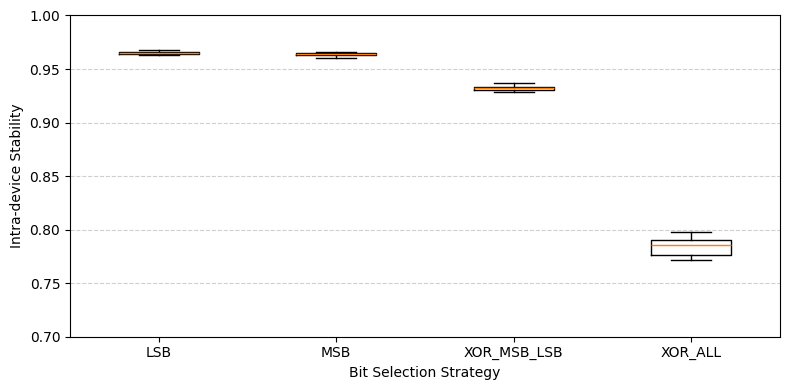

In [ ]:
plt.figure(figsize=(8, 4))
plt.boxplot(
    [intra_device_stats[s] for s in strategies],
    labels=strategies,
    showfliers=False
)
plt.ylabel("Intra-device Stability")
plt.xlabel("Bit Selection Strategy")
plt.ylim(0.7, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
strategies = ["LSB", "MSB"]

enrolled = {s: {} for s in strategies}

for i in range(1, 11):
    fname = f"Address/sram{i}.txt"
    boots = parse_device_file(fname)

    for s in strategies:
        enrolled[s][f"Device_{i}"] = enrolled_response(boots, s)


In [ ]:
import pandas as pd
import numpy as np

def inter_device_table(enrolled_strategy):
    devices = list(enrolled_strategy.keys())
    n = len(devices)

    table = np.zeros((n, n))

    for i, d1 in enumerate(devices):
        for j, d2 in enumerate(devices):
            r1 = enrolled_strategy[d1]
            r2 = enrolled_strategy[d2]

            common = r1.keys() & r2.keys()
            hd = sum(r1[a] ^ r2[a] for a in common) / len(common)

            table[i, j] = hd

    return pd.DataFrame(table, index=devices, columns=devices)


In [ ]:
lsb_table = inter_device_table(enrolled["LSB"])
msb_table = inter_device_table(enrolled["MSB"])

print("LSB inter device table")
print(lsb_table)

print("\nMSB inter device table")
print(msb_table)

LSB inter device table
           Device_1  Device_2  Device_3  Device_4  Device_5  Device_6  \
Device_1   0.000000  0.015625  0.498532  0.489746  0.479980  0.497559   
Device_2   0.015625  0.000000  0.497554  0.489746  0.480957  0.493652   
Device_3   0.498532  0.497554  0.000000  0.474560  0.513209  0.518591   
Device_4   0.489746  0.489746  0.474560  0.000000  0.485352  0.513672   
Device_5   0.479980  0.480957  0.513209  0.485352  0.000000  0.477539   
Device_6   0.497559  0.493652  0.518591  0.513672  0.477539  0.000000   
Device_7   0.507812  0.508789  0.501957  0.492676  0.492676  0.497559   
Device_8   0.507324  0.513184  0.509785  0.488281  0.486328  0.493164   
Device_9   0.487793  0.486816  0.499022  0.485352  0.475586  0.494141   
Device_10  0.510763  0.514677  0.499020  0.498532  0.478474  0.511742   

           Device_7  Device_8  Device_9  Device_10  
Device_1   0.507812  0.507324  0.487793   0.510763  
Device_2   0.508789  0.513184  0.486816   0.514677  
Device_3   0.5

In [ ]:
print(lsb_table.to_latex(
    float_format="%.4f",
    caption="Inter device Hamming distance using LSB",
    label="tab:inter_device_lsb"
))

print(msb_table.to_latex(
    float_format="%.4f",
    caption="Inter device Hamming distance using MSB",
    label="tab:inter_device_msb"
))


\begin{table}
\caption{Inter device Hamming distance using LSB}
\label{tab:inter_device_lsb}
\begin{tabular}{lrrrrrrrrrr}
\toprule
 & Device_1 & Device_2 & Device_3 & Device_4 & Device_5 & Device_6 & Device_7 & Device_8 & Device_9 & Device_10 \\
\midrule
Device_1 & 0.0000 & 0.0156 & 0.4985 & 0.4897 & 0.4800 & 0.4976 & 0.5078 & 0.5073 & 0.4878 & 0.5108 \\
Device_2 & 0.0156 & 0.0000 & 0.4976 & 0.4897 & 0.4810 & 0.4937 & 0.5088 & 0.5132 & 0.4868 & 0.5147 \\
Device_3 & 0.4985 & 0.4976 & 0.0000 & 0.4746 & 0.5132 & 0.5186 & 0.5020 & 0.5098 & 0.4990 & 0.4990 \\
Device_4 & 0.4897 & 0.4897 & 0.4746 & 0.0000 & 0.4854 & 0.5137 & 0.4927 & 0.4883 & 0.4854 & 0.4985 \\
Device_5 & 0.4800 & 0.4810 & 0.5132 & 0.4854 & 0.0000 & 0.4775 & 0.4927 & 0.4863 & 0.4756 & 0.4785 \\
Device_6 & 0.4976 & 0.4937 & 0.5186 & 0.5137 & 0.4775 & 0.0000 & 0.4976 & 0.4932 & 0.4941 & 0.5117 \\
Device_7 & 0.5078 & 0.5088 & 0.5020 & 0.4927 & 0.4927 & 0.4976 & 0.0000 & 0.4995 & 0.4946 & 0.4858 \\
Device_8 & 0.5073 & 0.5132 & 0.

In [ ]:
devices, file_names = load_all(DATA_FOLDER)
